In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from pathlib import Path

from tensorflow.keras.applications import DenseNet121


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

## Loading dataset 

In [ ]:
data = pd.read_csv(r"C:\Users\hp\Desktop\Honey Bee Pollen Detection\PollenDataset\pollen_data.csv",usecols=['filename', 'pollen_carrying'])

In [3]:
data

,filename,pollen_carrying
0,P10057-125r.jpg,1
1,P57380-120r.jpg,1
2,NP63671-221r.jpg,0
3,NP53776-47r.jpg,0
4,NP13382-201r.jpg,0
...,...,...
709,NP64239-233r.jpg,0
710,NP10304-132r.jpg,0
711,NP28671-238r.jpg,0
712,P14163-218r.jpg,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [5]:
import os

path = os.path.join(r"C:\Users\hp\Desktop\Honey Bee Pollen Detection\PollenDataset\images", 'P10057-125r.jpg')

## Preprocessing

In [6]:
def preprocess_df(df, image_path):
    df = df.copy()
    
    # Change filenames into filepaths
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)
    
    # Create text labels for the images
    df['pollen_carrying'] = df['pollen_carrying'].replace({0: "NO POLLEN", 1: "POLLEN"})
    
    # Train-test split
    train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)
    
    return train_df, test_df

In [7]:
train_df, test_df = preprocess_df(data, image_path=(r"C:\Users\hp\Desktop\Honey Bee Pollen Detection\PollenDataset\images"))

In [8]:
train_df

,filename,pollen_carrying
507,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,POLLEN
346,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,NO POLLEN
160,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,POLLEN
463,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,NO POLLEN
432,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,POLLEN
...,...,...
144,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,POLLEN
645,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,NO POLLEN
72,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,POLLEN
235,C:\Users\hp\Desktop\Honey Bee Pollen Detection...,NO POLLEN


## Loading the DenseNet121 model without the top classification layer

In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

## Freezing the pre trained layer

In [10]:
for layer in base_model.layers:
    layer.trainable = False

## Adding the classification layers on top 

In [11]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Change to 1 output unit for binary classification
])

## Compiling the model

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Creating Generators 

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

## Training

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 400 validated image filenames belonging to 2 classes.
Found 99 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


In [25]:
history = model.fit(train_images, batch_size=32, epochs=10, validation_data=val_images)

Epoch 1/10
13/13 [==============================] - 86s 7s/step - loss: 0.1078 - accuracy: 0.9550 - val_loss: 0.2668 - val_accuracy: 0.8990
Epoch 2/10
13/13 [==============================] - 85s 7s/step - loss: 0.1511 - accuracy: 0.9475 - val_loss: 0.1735 - val_accuracy: 0.9394
Epoch 3/10
13/13 [==============================] - 86s 7s/step - loss: 0.1255 - accuracy: 0.9450 - val_loss: 0.1567 - val_accuracy: 0.9394
Epoch 4/10
13/13 [==============================] - 83s 6s/step - loss: 0.0862 - accuracy: 0.9675 - val_loss: 0.1662 - val_accuracy: 0.9293
Epoch 5/10
13/13 [==============================] - 86s 7s/step - loss: 0.0866 - accuracy: 0.9675 - val_loss: 0.2273 - val_accuracy: 0.8889
Epoch 6/10
13/13 [==============================] - 85s 7s/step - loss: 0.1569 - accuracy: 0.9325 - val_loss: 0.2316 - val_accuracy: 0.8889
Epoch 7/10
13/13 [==============================] - 83s 6s/step - loss: 0.0825 - accuracy: 0.9725 - val_loss: 0.2107 - val_accuracy: 0.9091
Epoch 8/10
13/13 [==

## Results 

Accuracy: 92.56%
7/7 [==============================] - 64s 9s/step


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


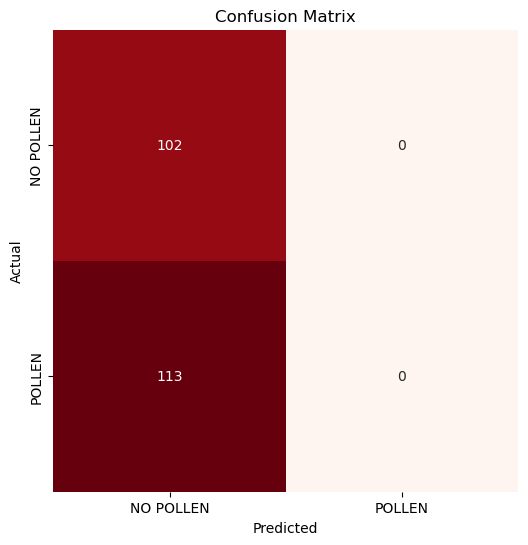

Classification Report:
----------------------
               precision    recall  f1-score   support

   NO POLLEN       0.47      1.00      0.64       102
      POLLEN       0.00      0.00      0.00       113

    accuracy                           0.47       215
   macro avg       0.24      0.50      0.32       215
weighted avg       0.23      0.47      0.31       215



In [26]:
results = model.evaluate(test_images, verbose=0)
print("Accuracy: {:.2f}%".format(results[1] * 100))

# Obtain the predicted probabilities
predicted_probs = model.predict(test_images)
# Convert probabilities to binary predictions
predictions = np.argmax(predicted_probs, axis=1)

true_labels = test_images.classes

cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
clr = classification_report(true_labels, predictions, labels=[0, 1], target_names=["NO POLLEN", "POLLEN"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Reds', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["NO POLLEN", "POLLEN"])
plt.yticks(ticks=[0.5, 1.5], labels=["NO POLLEN", "POLLEN"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

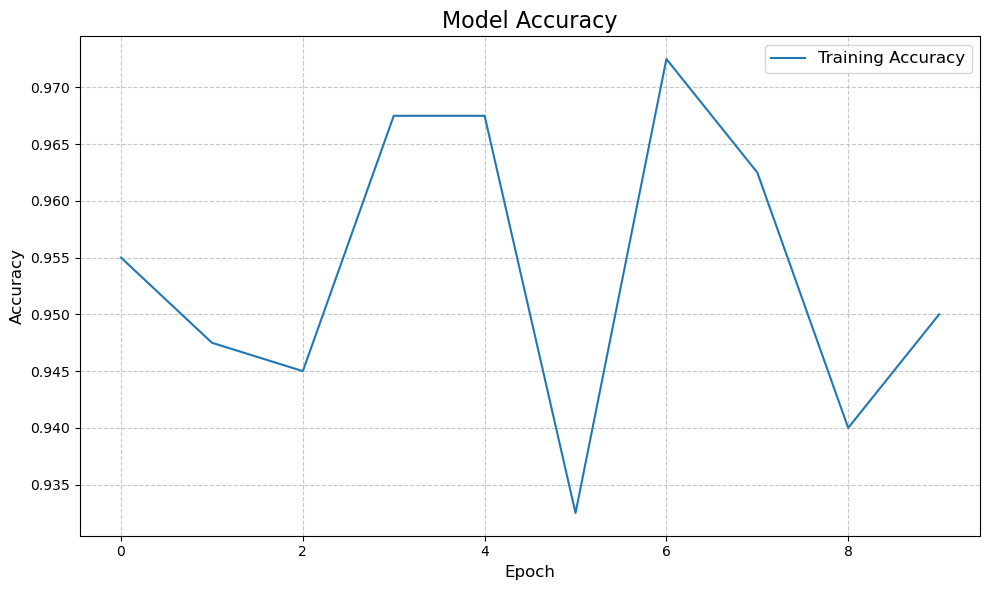

In [28]:
# Plot model accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')  
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

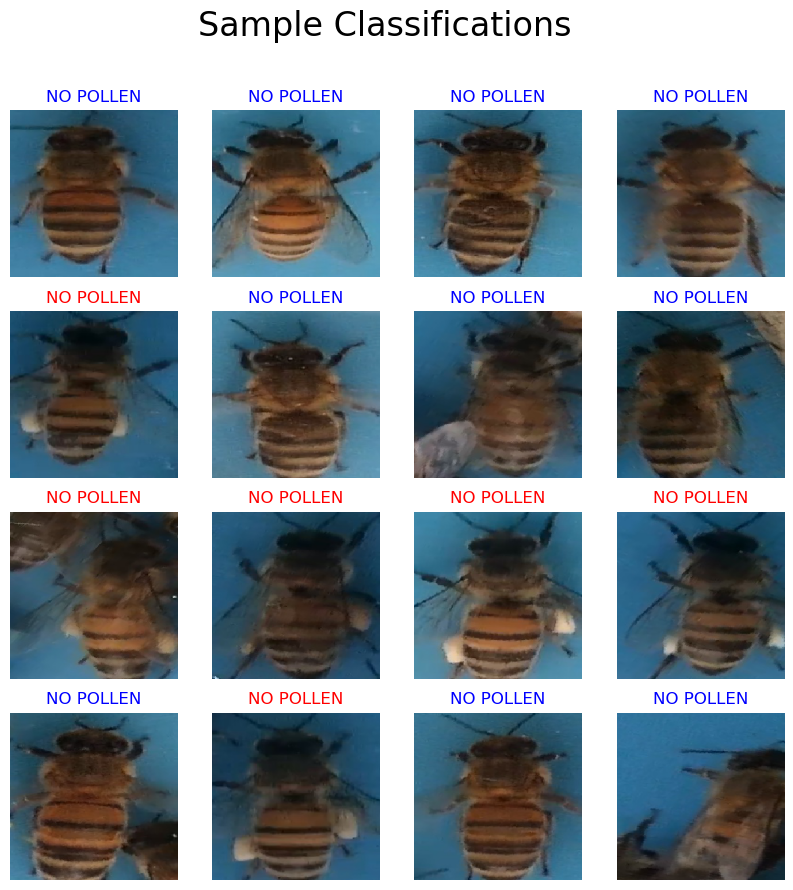

In [27]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[0][0][i])
    plt.title(
        "NO POLLEN" if predictions[i] == 0 else "POLLEN",
        color='blue' if predictions[i] == test_images.labels[i] else 'red'
    )
    plt.axis('off')

plt.suptitle("Sample Classifications", size=24)
plt.show()